In [125]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

## 1. Загрузка данных

In [126]:
glass_df = pd.read_csv('./Data/glass.csv')
glass_df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


### 1.2 Проверка на дисбаланс классов

In [127]:
glass_df['Type'].value_counts()

2    76
1    70
7    29
3    17
5    13
6     9
Name: Type, dtype: int64

> В классах присутствует дисбаланс

## 2. Раздление данных на train и test

In [128]:
X = glass_df.drop('Type', axis=1)
y = glass_df['Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## 3. Построение и обучение модели случайного леса

In [129]:
random_forest_clf = RandomForestClassifier().fit(X_train, y_train)

## 4. Оценка качества модели

In [130]:
y_true_test = y_test
y_pred_test = random_forest_clf.predict(X_test)

accuracy_score_model_with_outliers = accuracy_score(y_pred_test, y_true_test)

## 5. Обработка выбросов

### 5.1 Визуализация распределений

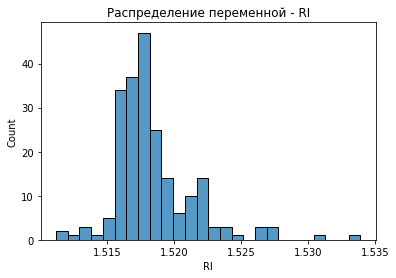

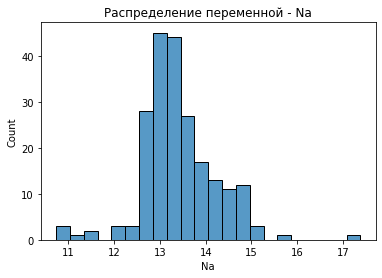

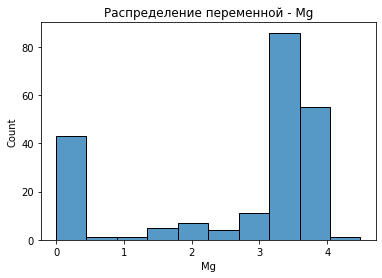

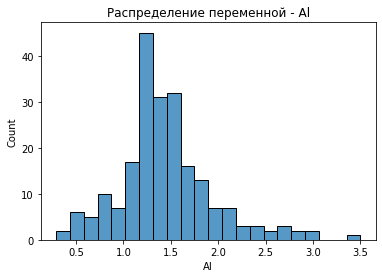

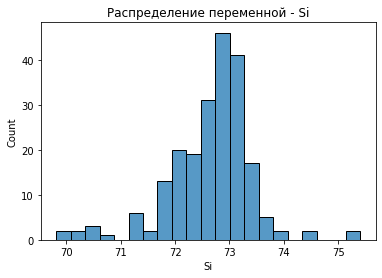

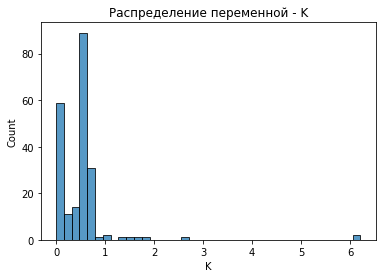

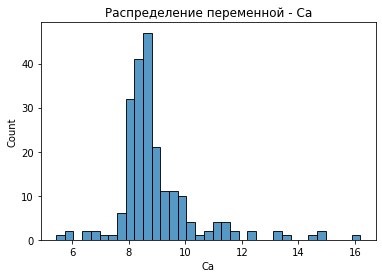

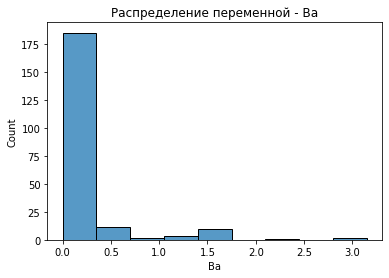

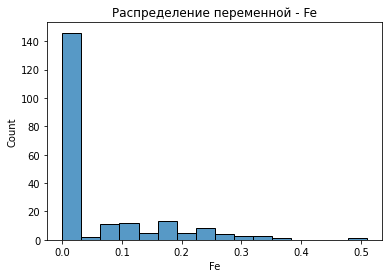

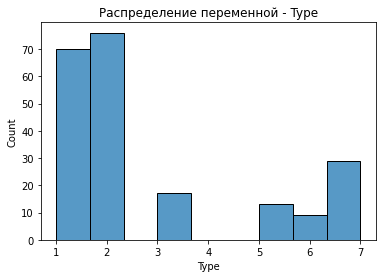

In [131]:
for feature in glass_df.columns:
    sns.histplot(glass_df[feature])
    plt.title(f'Распределение переменной - {feature}')
    plt.show()

> Признак с нормальным распределением тут только - Si

### 5.2 Исследование на выбросы + удаление

In [132]:
df_without_outliers = pd.DataFrame()

for feature in glass_df.columns[:-1]:
    Q1, Q3 = np.quantile(glass_df[feature], [0.25, 0.75])
    IQR = Q3 - Q1
    
    upper_bound = Q1 - 1.5 * IQR
    lower_bound = Q3 + 1.5 * IQR
    
    df_without_outliers = pd.concat([
        df_without_outliers,
        glass_df[~((glass_df[feature] <= Q1) | (glass_df[feature] >= Q3))]
    ])
    
    df_without_outliers.reset_index(drop=True)
    df_without_outliers.drop_duplicates(inplace=True)

### 5.3 Процент удаленных записей от общего числа записей для каждого класса.

In [133]:
class_names = glass_df['Type'].value_counts().index
glass_df_value_count, df_without_outliers_value_counts = np.array(glass_df['Type'].value_counts()), \
                                                         np.array(df_without_outliers['Type'].value_counts())

for i in range(len(glass_df_value_count)):
    total_number_of_class_rows = glass_df_value_count[i]
    number_of_class_rows_without_outliers = df_without_outliers_value_counts[i]
    
    lost_values = total_number_of_class_rows - number_of_class_rows_without_outliers
    print(f'Класс - {class_names[i]}, процент потерь от общего число = {np.round(lost_values / total_number_of_class_rows, 2)}')

Класс - 2, процент потерь от общего число = 0.05
Класс - 1, процент потерь от общего число = 0.06
Класс - 7, процент потерь от общего число = 0.0
Класс - 3, процент потерь от общего число = 0.12
Класс - 5, процент потерь от общего число = 0.08
Класс - 6, процент потерь от общего число = 0.22


## 6. Обучение модели на данных без выбросов

### 6.1 Разделение данных на train и test

In [134]:
X = df_without_outliers.drop('Type', axis=1)
y = df_without_outliers['Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### 6.2 Обучение и оценка результатов

In [135]:
random_forest_clf = RandomForestClassifier().fit(X_train, y_train)

In [136]:
y_true_test = y_test
y_pred_test = random_forest_clf.predict(X_test)

accuracy_score_without_outliers = accuracy_score(y_pred_test, y_true_test)

## Выводы

In [137]:
print(f'Метрика модели с данными содержащие выбросы = {accuracy_score_model_with_outliers}')
print(f'Метрика модели с данными без выбросов = {accuracy_score_without_outliers}')

Метрика модели с данными содержащие выбросы = 0.813953488372093
Метрика модели с данными без выбросов = 0.7560975609756098


1. К данным я применил метод поиска выбросов через межквартильный размах
2. Как мы видим по результатам модель без выбросов справилась лучше, чем модель которая обучалась на данных без выбросов
3. Выбросы в данных нужно удалять, чтобы моделям было проще обучаться(она быстрее находит закономерности)